In [1]:
import Higgs.predictions as HP
from Higgs.tools.ImplementationUtils import readHEPDataCsv,implementMeasurement
from Higgs.tools.MeasurementValidation import *
import Higgs.signals as HS
import numpy as np


## ATLAS `H>mumu` 139fb-1 [2007.07830](https://arxiv.org/abs/2007.07830)

In [2]:
measFile = implementMeasurement(
    "2007.07830",
    "Fig. 2 (combined result)",
    {
        "mumu": {
            "obs": [0.6, 1.2, 1.8],
            "ref": [1, 1, 1],  # signal strength measurement
            "process": {
                "channels": [[p, "mumu"] for p in ["H", "vbfH", "HZ", "HW", "Htt"]]
            },
        }
    },
    prefix="mumu",
    referenceMass=125,
    massResolution=3,
)

meas = HS.Measurement(measFile)
pred = HP.Predictions()
h = pred.addParticle(HP.NeutralScalar("h"))
h.setMass(meas.referenceMass())
HP.effectiveCouplingInput(h, HP.smLikeEffCouplings, reference=meas.referenceModel())
assert np.isclose(meas(pred, {"mumu": 5 * [1.2]}), 0)


Looks good. Saving this to mumu_LHC13_ATLAS_139.json


## CMS `H>mumu` combination 137fb-1 [2009.04363](http://arxiv.org/abs/2009.04363)

In [3]:
df = (
    readHEPDataCsv(
        "https://www.hepdata.net/download/table/ins1815813/Signal%20strength%20per%20category/1/csv"
    )[0]
    .set_index("Categories")
    .drop(index=["Combined"])
    .rename(
        index=lambda x: x.split(" ")[0],
        columns={
            "Signal strength modifier": "obs",
            "68% CL interval +": "obs+",
            "68% CL interval -": "obs-",
        },
    )
)
df["obs+"] += df.obs
df["obs-"] += df.obs

bins = {
    k: {"obs": [r["obs-"], r["obs"], r["obs+"]], "ref": [1.0, 1.0, 1.0]}
    for k, r in df.iterrows()
}
bins["ggH"]["process"] = {"channels": [["H", "mumu"]]}
bins["VBF"]["process"] = {"channels": [["vbfH", "mumu"]]}
bins["ttH"]["process"] = {"channels": [[p, "mumu"] for p in ("Htt", "Ht", "HtW")]}
bins["VH"]["process"] = {"channels": [[p, "mumu"] for p in ("HW", "HZ")]}
measFile = implementMeasurement(
    "2009.04363",
    "Fig. 11 (left)",
    bins,
    prefix="mumu",
    referenceMass=125.38,
    massResolution=1.7,  # Aux. Fig. 13
)


Multiple different luminosity values: [137.0, 19.7] using 137.0 unless you set it manually
Looks good. Saving this to mumu_LHC13_CMS_137.json


No correlation information is given, so this fits Fig. 11 (right) about as good as can be expected.

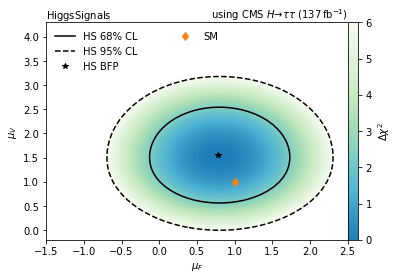

In [4]:
meas = HS.Measurement(measFile)

mu1 = np.linspace(-1.5, 2.5)
mu2 = np.linspace(-0.2, 4.3)


def modFacs(muF, muV):
    return {
        x: 3 * [muF] if x == "ggH" or x == "ttH" else [muV]
        for x in bins.keys()
    }


fig, ax = validateMeasurementModFactors(
    meas,
    mu1,
    mu2,
    modFacs,
    r"$H\to \tau\tau$",
)
ax.plot(1, 1, marker="d", c="tab:orange", ls="none", label="SM")
ax.legend(loc="upper center", frameon=False)

ax.set_xlabel(r"$\mu_F$")
ax.set_ylabel(r"$\mu_V$");
